## 데이터 준비 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/Exploration/9.sentimental_analysis/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/Exploration/9.sentimental_analysis/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터 로더 준비

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델구성을 위한 데이터 분석 / 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가


In [5]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대: ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를 들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2.5*np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences_maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 이내에 포함됨'.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969376315021577
문장길이 최대:  116
문장길이 표준편차 :  12.843535456326455
pad_sequences_maxlen :  48
전체 문장의 0.9548784420929768%가 maxlen 이내에 포함됨


In [6]:
x_train = keras.preprocessing.sequence.pad_sequences(X_train, 
                                                    value=word_to_index['<PAD>'],
                                                    padding='pre',
                                                    maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                   value=word_to_index['<PAD>'],
                                                   padding='pre',
                                                   maxlen=maxlen)

print(x_train.shape)

(146182, 48)


## 모델 구성, validation set

In [27]:
vocab_size = 10000 # 어휘 사전 크기
word_vector_dim = 128 # 워드 벡터 차원수
seed = 2020

In [79]:
def Global():
    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dense(128))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(64))
    model.add(keras.layers.Dropout(0.2, seed=seed))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

    model.summary()
    return model

In [80]:
def Cnn():
    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
    model.add(keras.layers.Conv1D(128, 7, activation='relu'))
    model.add(keras.layers.MaxPooling1D())
    model.add(keras.layers.Conv1D(64, 7, activation='relu'))
    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dense(64))
    model.add(keras.layers.Dropout(0.2, seed=seed))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(1, activation='sigmoid')) # 최종 출력 = 긍/부정 = 1dim

    model.summary()
    return model

In [81]:
def Rnn():
    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
    model.add(keras.layers.GRU(128, return_sequences=True))  # 가장 널리 쓰이는 RNN인 LSTM 모델, LSTM 벡터의 차원수 = 128
    model.add(keras.layers.GRU(64, return_sequences=False))  # 가장 널리 쓰이는 RNN인 LSTM 모델, LSTM 벡터의 차원수 = 128
    model.add(keras.layers.Dense(64))
    model.add(keras.layers.Dropout(0.5, seed=seed))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(1, activation='sigmoid')) # 긍/부정을 나타내는 1dim

    model.summary()
    return model

In [82]:
# model 설계
model_select = {'global': Global, 'cnn': Cnn, 'rnn': Rnn}

model_global = model_select['global']()
model_cnn = model_select['cnn']()
model_rnn = model_select['rnn']()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 128)         1280000   
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 128)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
re_lu_16 (ReLU)              (None, 128)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)              

In [83]:
x_val = x_train[:30000]
y_val = y_train[:30000]

# validation 제외한 나머지
partial_x_train = x_train[30000:]
partial_y_train = y_train[30000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(116182, 48)
(116182,)


## Training

In [84]:
epochs = 20
lr = 1e-4
decay = 5e-4
adam = keras.optimizers.Adam(learning_rate=lr, decay=decay)

In [85]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# Set callback functions to early stop training and save the best model so far
callbacks = {}
key_list = ['global', 'cnn', 'rnn']

model_dir = '/home/aiffel0049/aiffel/Exploration/9.sentimental_analysis/model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_path = {}
for key in key_list:
    model_path[key] = f'{model_dir}/best_model_{key}.h5'
#     callbacks[key] = [EarlyStopping(patience=5),
#                       ModelCheckpoint(filepath=model_path[key], monitor='val_loss', save_best_only=True, mode='min')
#                      ]
    callbacks[key] = [ModelCheckpoint(filepath=model_path[key], monitor='val_loss', save_best_only=True, mode='min')
                     ]
    

In [86]:
model_global.compile(optimizer=adam,
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

history_global = model_global.fit(partial_x_train,
                               partial_y_train,
                               epochs=epochs,
                               callbacks=callbacks['global'],
                               batch_size=512,
                               validation_data=(x_val, y_val),
                               verbose=1)

Epoch 1/20
227/227 [==============================] - 3s 14ms/step - loss: 0.6807 - accuracy: 0.6350 - val_loss: 0.6399 - val_accuracy: 0.7762
Epoch 2/20
227/227 [==============================] - 3s 14ms/step - loss: 0.5232 - accuracy: 0.7993 - val_loss: 0.4125 - val_accuracy: 0.8254
Epoch 3/20
227/227 [==============================] - 3s 14ms/step - loss: 0.3819 - accuracy: 0.8369 - val_loss: 0.3630 - val_accuracy: 0.8394
Epoch 4/20
227/227 [==============================] - 3s 14ms/step - loss: 0.3431 - accuracy: 0.8546 - val_loss: 0.3502 - val_accuracy: 0.8462
Epoch 5/20
227/227 [==============================] - 3s 14ms/step - loss: 0.3219 - accuracy: 0.8664 - val_loss: 0.3445 - val_accuracy: 0.8497
Epoch 6/20
227/227 [==============================] - 3s 14ms/step - loss: 0.3068 - accuracy: 0.8740 - val_loss: 0.3415 - val_accuracy: 0.8514
Epoch 7/20
227/227 [==============================] - 3s 14ms/step - loss: 0.2935 - accuracy: 0.8800 - val_loss: 0.3401 - val_accuracy: 0.8526

In [87]:
model_cnn.compile(optimizer=adam,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

history_cnn = model_cnn.fit(partial_x_train,
                           partial_y_train,
                           epochs=epochs,
                           callbacks=callbacks['cnn'],
                           batch_size=512,
                           validation_data=(x_val, y_val),
                           verbose=1)

Epoch 1/20
227/227 [==============================] - 5s 22ms/step - loss: 0.6338 - accuracy: 0.6458 - val_loss: 0.4724 - val_accuracy: 0.7929
Epoch 2/20
227/227 [==============================] - 5s 21ms/step - loss: 0.4233 - accuracy: 0.8141 - val_loss: 0.3850 - val_accuracy: 0.8324
Epoch 3/20
227/227 [==============================] - 5s 21ms/step - loss: 0.3722 - accuracy: 0.8413 - val_loss: 0.3668 - val_accuracy: 0.8405
Epoch 4/20
227/227 [==============================] - 5s 20ms/step - loss: 0.3508 - accuracy: 0.8531 - val_loss: 0.3573 - val_accuracy: 0.8440
Epoch 5/20
227/227 [==============================] - 5s 20ms/step - loss: 0.3372 - accuracy: 0.8606 - val_loss: 0.3536 - val_accuracy: 0.8469
Epoch 6/20
227/227 [==============================] - 5s 20ms/step - loss: 0.3277 - accuracy: 0.8654 - val_loss: 0.3505 - val_accuracy: 0.8486
Epoch 7/20
227/227 [==============================] - 5s 21ms/step - loss: 0.3201 - accuracy: 0.8703 - val_loss: 0.3492 - val_accuracy: 0.8487

In [88]:
model_rnn.compile(optimizer=adam,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

history_rnn = model_rnn.fit(partial_x_train,
                           partial_y_train,
                           epochs=epochs,
                           callbacks=callbacks['rnn'],
                           batch_size=512,
                           validation_data=(x_val, y_val),
                           verbose=1)

Epoch 1/20
227/227 [==============================] - 6s 27ms/step - loss: 0.6119 - accuracy: 0.7028 - val_loss: 0.4574 - val_accuracy: 0.7940
Epoch 2/20
227/227 [==============================] - 6s 25ms/step - loss: 0.4195 - accuracy: 0.8187 - val_loss: 0.3972 - val_accuracy: 0.8235
Epoch 3/20
227/227 [==============================] - 6s 25ms/step - loss: 0.3795 - accuracy: 0.8387 - val_loss: 0.3761 - val_accuracy: 0.8373
Epoch 4/20
227/227 [==============================] - 5s 22ms/step - loss: 0.3612 - accuracy: 0.8471 - val_loss: 0.3667 - val_accuracy: 0.8406
Epoch 5/20
227/227 [==============================] - 6s 25ms/step - loss: 0.3498 - accuracy: 0.8530 - val_loss: 0.3616 - val_accuracy: 0.8434
Epoch 6/20
227/227 [==============================] - 6s 25ms/step - loss: 0.3416 - accuracy: 0.8570 - val_loss: 0.3579 - val_accuracy: 0.8436
Epoch 7/20
227/227 [==============================] - 6s 27ms/step - loss: 0.3358 - accuracy: 0.8602 - val_loss: 0.3553 - val_accuracy: 0.8448

## loss, accuracy 그래프

In [89]:
model_global.load_weights(model_path['global'])
model_cnn.load_weights(model_path['cnn'])
model_rnn.load_weights(model_path['rnn'])

In [90]:
results_global = model_global.evaluate(x_test, y_test, verbose=2)
results_cnn = model_cnn.evaluate(x_test, y_test, verbose=2)
results_rnn = model_rnn.evaluate(x_test, y_test, verbose=2)

print(results_global)
print(results_cnn)
print(results_rnn)

1537/1537 - 2s - loss: 0.3500 - accuracy: 0.8488
1537/1537 - 2s - loss: 0.3603 - accuracy: 0.8444
1537/1537 - 4s - loss: 0.3619 - accuracy: 0.8441
[0.34996798634529114, 0.848831295967102]
[0.36027708649635315, 0.8443965315818787]
[0.36194688081741333, 0.8440710306167603]


In [91]:
acc_global = str(results_global[-1])[:10]
acc_cnn = str(results_cnn[-1])[:10]
acc_rnn = str(results_rnn[-1])[:10]

os.rename(model_path['global'], model_path['global'].split('.h5')[0] + acc_global + '.h5')
os.rename(model_path['cnn'], model_path['cnn'].split('.h5')[0] + acc_cnn + '.h5')
os.rename(model_path['rnn'], model_path['rnn'].split('.h5')[0] + acc_rnn + '.h5')

In [92]:
history_list = {}
history_list['global'] = history_global.history
history_list['cnn'] = history_cnn.history
history_list['rnn'] = history_rnn.history

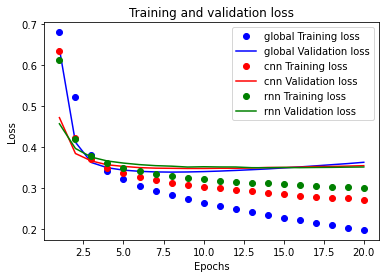

In [93]:
import matplotlib.pyplot as plt

acc, val_acc, loss, val_loss = dict(), dict(), dict(), dict()
for key, history_dict in history_list.items():
    acc[key] = history_dict['accuracy']
    val_acc[key] = history_dict['val_accuracy']
    loss[key] = history_dict['loss']
    val_loss[key] = history_dict['val_loss']

# 'bo'는 파란색 점
point_color = ['bo', 'ro', 'go']
# b는 파란 실선
line_color = ['b', 'r', 'g']

for i, key in enumerate(key_list):
    epochs_x = range(1, len(loss[key]) + 1)
    plt.plot(epochs, loss[key], point_color[i], label=f'{key} Training loss')
    plt.plot(epochs, val_loss[key], line_color[i], label=f'{key} Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

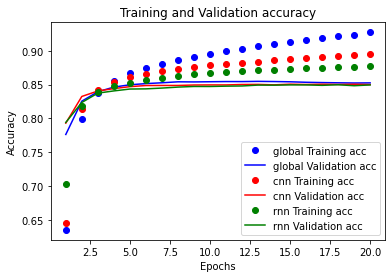

In [94]:
plt.clf()

for i, key in enumerate(key_list):
    epochs_x = range(1, len(acc[key]) + 1)
    plt.plot(epochs, acc[key], point_color[i], label=f'{key} Training acc')
    plt.plot(epochs, val_acc[key], line_color[i], label=f'{key} Validation acc')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 학습된 embedding 레이어 분석

In [95]:
embedding_layer = model_rnn.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 128)


In [96]:
vectors = {}
vectors['global'] = model_global.get_weights()[0]
vectors['cnn'] = model_cnn.get_weights()[0]
vectors['rnn'] = model_rnn.get_weights()[0]


for key in key_list:
    # 학습한 embedding 파라미터 > 파일에 저장
    word2vec_file_path = f'/home/aiffel0049/aiffel/Exploration/9.sentimental_analysis/word2vec_{key}_project.txt'
    f = open(word2vec_file_path, 'w')
    f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) # 몇개 벡터를 얼마 사이즈로 기재할지 타이틀 작성

    # 단어 개수(에서 4개 제외)만큼의 워드 벡터를 파일에 기록
    for i in range(4, vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[key][i, :])))))
    f.close()

In [97]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([-0.00270493,  0.00377872,  0.03109179,  0.01314111,  0.03994388,
       -0.04892297, -0.03609091,  0.00527823, -0.01273051, -0.03136575,
       -0.01057074, -0.05054413, -0.00441846,  0.01440711,  0.01644847,
       -0.01080723,  0.01036276,  0.0243832 , -0.034647  ,  0.02427972,
       -0.03979651,  0.00454855, -0.0359513 , -0.04174156,  0.03995575,
       -0.03612015,  0.01171916,  0.00072598,  0.00587226,  0.02786089,
       -0.01905671,  0.02517821,  0.03236784,  0.00599099, -0.04245016,
       -0.04782908, -0.04932432, -0.02859404,  0.02877638,  0.04515447,
        0.00941646,  0.03146669,  0.00469072, -0.02535612,  0.03286137,
       -0.01203791, -0.01115565,  0.04748917,  0.02458333, -0.01616879,
        0.02417343, -0.01518521,  0.0447078 ,  0.01475264, -0.02503222,
       -0.03581374, -0.03897323,  0.0274309 ,  0.00470494, -0.04390552,
       -0.02987204, -0.04707195,  0.00328341,  0.02427638, -0.00731384,
        0.05066675,  0.02685889, -0.00602991, -0.00979867, -0.00

## 한국어 word2vec 임베딩 활용

- 한국어 Word2Vec   
    https://github.com/Kyubyong/wordvectors


- 한국어 Word2Vec 사용법   
    https://medium.com/@omicro03/%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC-nlp-14%EC%9D%BC%EC%B0%A8-word2vec-%EC%8B%A4%EC%8A%B52-8e518a358b6c

### word2vec load

In [112]:
from gensim.models import Word2Vec
word2vec_path = '/home/aiffel0049/aiffel/Exploration/9.sentimental_analysis/data/ko/ko.bin'
word2vec = Word2Vec.load(word2vec_path)
vector = word2vec["영화"]
vector.size

/home/aiffel0049/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


200

### word2vec 값을 embedding_matrix 에 저장하여 활용

In [128]:
word_vector_dim = 200
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/aiffel0049/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel0049/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [129]:
from tensorflow.keras.initializers import Constant
from tensorflow import keras

### 모델 선언

In [143]:
def Global_embed():
    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size,
                                     word_vector_dim,
                                     embeddings_initializer=Constant(embedding_matrix),
                                     input_shape=(None, ),
                                     trainable=True))
    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dense(256))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(128))
    model.add(keras.layers.Dropout(0.2, seed=seed))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

    model.summary()
    return model

In [144]:
def Cnn_embed():
    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size,
                                     word_vector_dim,
                                     embeddings_initializer=Constant(embedding_matrix),
                                     input_shape=(None, ),
                                     trainable=True))
    model.add(keras.layers.Conv1D(256, 7, activation='relu'))
    model.add(keras.layers.MaxPooling1D())
    model.add(keras.layers.Conv1D(128, 7, activation='relu'))
    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dense(128))
    model.add(keras.layers.Dropout(0.2, seed=seed))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(1, activation='sigmoid')) # 최종 출력 = 긍/부정 = 1dim

    model.summary()
    return model

In [145]:
def Rnn_embed():
    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size,
                                     word_vector_dim,
                                     embeddings_initializer=Constant(embedding_matrix),
                                     input_shape=(None, ),
                                     trainable=True))
    model.add(keras.layers.GRU(256, return_sequences=True))  # 가장 널리 쓰이는 RNN인 LSTM 모델, LSTM 벡터의 차원수 = 128
    model.add(keras.layers.GRU(128, return_sequences=False))  # 가장 널리 쓰이는 RNN인 LSTM 모델, LSTM 벡터의 차원수 = 128
    model.add(keras.layers.Dense(128))
    model.add(keras.layers.Dropout(0.5, seed=seed))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(1, activation='sigmoid')) # 긍/부정을 나타내는 1dim

    model.summary()
    return model

In [167]:
# model 설계
model_select = {'global_embed': Global_embed, 'cnn_embed': Cnn_embed, 'rnn_embed': Rnn_embed}

model_global_embed = model_select['global_embed']()
model_cnn_embed = model_select['cnn_embed']()
model_rnn_embed = model_select['rnn_embed']()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, None, 200)         2000000   
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 200)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 128)               25728     
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
re_lu_24 (ReLU)              (None, 128)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_25 (Dropout)         (None, 64)              

### 모델 학습

In [170]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# Set callback functions to early stop training and save the best model so far
callbacks = {}
key_list_embed = ['global_embed', 'cnn_embed', 'rnn_embed']

model_path = {}
for key in key_list_embed:
    model_path[key] = f'{model_dir}/best_model_{key}.h5'
#     callbacks[key] = [EarlyStopping(patience=5),
#                       ModelCheckpoint(filepath=model_path[key], monitor='val_loss', save_best_only=True, mode='min')
#                      ]
    callbacks[key] = [ModelCheckpoint(filepath=model_path[key], monitor='val_loss', save_best_only=True, mode='min')
                     ]

In [171]:
epochs = 100
lr = 1e-3
decay = 5e-4
adam = keras.optimizers.Adam(learning_rate=lr, decay=decay)

In [172]:
model_global_embed.compile(optimizer=adam,
                           loss='binary_crossentropy', 
                           metrics=['accuracy'])

history_global_embed = model_global_embed.fit(partial_x_train,
                                              partial_y_train,
                                              epochs=epochs,
                                              callbacks=callbacks['global_embed'],
                                              batch_size=512,
                                              validation_data=(x_val, y_val),
                                              verbose=1)

Epoch 1/100
227/227 [==============================] - 6s 27ms/step - loss: 0.5883 - accuracy: 0.6859 - val_loss: 0.5437 - val_accuracy: 0.7244
Epoch 2/100
227/227 [==============================] - 6s 27ms/step - loss: 0.5398 - accuracy: 0.7263 - val_loss: 0.5093 - val_accuracy: 0.7490
Epoch 3/100
227/227 [==============================] - 6s 27ms/step - loss: 0.5026 - accuracy: 0.7556 - val_loss: 0.4870 - val_accuracy: 0.7646
Epoch 4/100
227/227 [==============================] - 6s 27ms/step - loss: 0.4750 - accuracy: 0.7748 - val_loss: 0.4684 - val_accuracy: 0.7747
Epoch 5/100
227/227 [==============================] - 6s 27ms/step - loss: 0.4535 - accuracy: 0.7874 - val_loss: 0.4631 - val_accuracy: 0.7763
Epoch 6/100
227/227 [==============================] - 6s 26ms/step - loss: 0.4346 - accuracy: 0.8001 - val_loss: 0.4415 - val_accuracy: 0.7921
Epoch 7/100
227/227 [==============================] - 6s 26ms/step - loss: 0.4212 - accuracy: 0.8080 - val_loss: 0.4323 - val_accuracy:

In [173]:
model_cnn_embed.compile(optimizer=adam,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

history_cnn_embed = model_cnn_embed.fit(partial_x_train,
                           partial_y_train,
                           epochs=epochs,
                           callbacks=callbacks['cnn_embed'],
                           batch_size=512,
                           validation_data=(x_val, y_val),
                           verbose=1)

Epoch 1/100
227/227 [==============================] - 8s 36ms/step - loss: 0.5875 - accuracy: 0.6803 - val_loss: 0.5106 - val_accuracy: 0.7491
Epoch 2/100
227/227 [==============================] - 8s 35ms/step - loss: 0.4809 - accuracy: 0.7705 - val_loss: 0.4701 - val_accuracy: 0.7767
Epoch 3/100
227/227 [==============================] - 8s 36ms/step - loss: 0.4325 - accuracy: 0.8021 - val_loss: 0.4463 - val_accuracy: 0.7907
Epoch 4/100
227/227 [==============================] - 8s 35ms/step - loss: 0.3974 - accuracy: 0.8224 - val_loss: 0.4303 - val_accuracy: 0.8003
Epoch 5/100
227/227 [==============================] - 8s 35ms/step - loss: 0.3677 - accuracy: 0.8400 - val_loss: 0.4230 - val_accuracy: 0.8063
Epoch 6/100
227/227 [==============================] - 8s 36ms/step - loss: 0.3414 - accuracy: 0.8549 - val_loss: 0.4148 - val_accuracy: 0.8106
Epoch 7/100
227/227 [==============================] - 8s 35ms/step - loss: 0.3207 - accuracy: 0.8658 - val_loss: 0.4123 - val_accuracy:

In [174]:
model_rnn_embed.compile(optimizer=adam,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

history_rnn_embed = model_rnn_embed.fit(partial_x_train,
                           partial_y_train,
                           epochs=epochs,
                           callbacks=callbacks['rnn_embed'],
                           batch_size=512,
                           validation_data=(x_val, y_val),
                           verbose=1)

Epoch 1/100
227/227 [==============================] - 9s 40ms/step - loss: 0.5856 - accuracy: 0.6839 - val_loss: 0.4995 - val_accuracy: 0.7566
Epoch 2/100
227/227 [==============================] - 9s 40ms/step - loss: 0.4842 - accuracy: 0.7716 - val_loss: 0.4648 - val_accuracy: 0.7773
Epoch 3/100
227/227 [==============================] - 9s 40ms/step - loss: 0.4478 - accuracy: 0.7968 - val_loss: 0.4265 - val_accuracy: 0.8041
Epoch 4/100
227/227 [==============================] - 9s 39ms/step - loss: 0.4243 - accuracy: 0.8103 - val_loss: 0.4093 - val_accuracy: 0.8133
Epoch 5/100
227/227 [==============================] - 9s 38ms/step - loss: 0.4081 - accuracy: 0.8192 - val_loss: 0.3979 - val_accuracy: 0.8188
Epoch 6/100
227/227 [==============================] - 9s 38ms/step - loss: 0.3927 - accuracy: 0.8276 - val_loss: 0.3870 - val_accuracy: 0.8259
Epoch 7/100
227/227 [==============================] - 9s 38ms/step - loss: 0.3823 - accuracy: 0.8327 - val_loss: 0.3787 - val_accuracy:

### 학습된 모델 중 Checkpoint 모델 Load 및 평가

In [175]:
model_global_embed.load_weights(model_path['global_embed'])
model_cnn_embed.load_weights(model_path['cnn_embed'])
model_rnn_embed.load_weights(model_path['rnn_embed'])

In [176]:
results_global_embed = model_global_embed.evaluate(x_test, y_test, verbose=2)
results_cnn_embed = model_cnn_embed.evaluate(x_test, y_test, verbose=2)
results_rnn_embed = model_rnn_embed.evaluate(x_test, y_test, verbose=2)

print(results_global_embed)
print(results_cnn_embed)
print(results_rnn_embed)

1537/1537 - 2s - loss: 0.4179 - accuracy: 0.8134
1537/1537 - 2s - loss: 0.4222 - accuracy: 0.8160
1537/1537 - 4s - loss: 0.3386 - accuracy: 0.8551
[0.41790854930877686, 0.8133938312530518]
[0.4222198724746704, 0.8159570097923279]
[0.33855772018432617, 0.8551172614097595]


In [177]:
acc_global_embed = str(results_global_embed[-1])[:10]
acc_cnn_embed = str(results_cnn_embed[-1])[:10]
acc_rnn_embed = str(results_rnn_embed[-1])[:10]

os.rename(model_path['global_embed'], model_path['global_embed'].split('.h5')[0] + acc_global_embed + '.h5')
os.rename(model_path['cnn_embed'], model_path['cnn_embed'].split('.h5')[0] + acc_cnn_embed + '.h5')
os.rename(model_path['rnn_embed'], model_path['rnn_embed'].split('.h5')[0] + acc_rnn_embed + '.h5')

### 학습 추이 그래프 그리기

In [178]:
history_list_embed = {}
history_list_embed['global_embed'] = history_global_embed.history
history_list_embed['cnn_embed'] = history_cnn_embed.history
history_list_embed['rnn_embed'] = history_rnn_embed.history

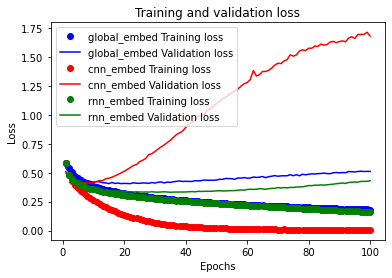

In [179]:
import matplotlib.pyplot as plt

acc, val_acc, loss, val_loss = dict(), dict(), dict(), dict()
for key, history_dict in history_list_embed.items():
    acc[key] = history_dict['accuracy']
    val_acc[key] = history_dict['val_accuracy']
    loss[key] = history_dict['loss']
    val_loss[key] = history_dict['val_loss']

# 'bo'는 파란색 점
point_color = ['bo', 'ro', 'go']
# 'b'는 파란 실선
line_color = ['b', 'r', 'g']

for i, key in enumerate(key_list_embed):
    epochs_x = range(1, len(loss[key]) + 1)
    plt.plot(epochs_x, loss[key], point_color[i], label=f'{key} Training loss')
    plt.plot(epochs_x, val_loss[key], line_color[i], label=f'{key} Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

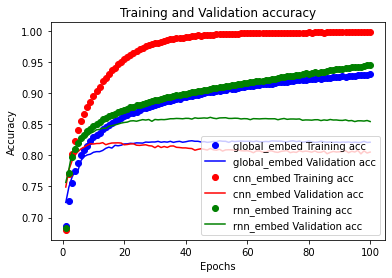

In [180]:
plt.clf()

for i, key in enumerate(key_list_embed):
    epochs_x = range(1, len(acc[key]) + 1)
    plt.plot(epochs_x, acc[key], point_color[i], label=f'{key} Training acc')
    plt.plot(epochs_x, val_acc[key], line_color[i], label=f'{key} Validation acc')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1. 첫 실험
    - 1 epoch 이후 모든 모델이 발산

2. dropout
    - 0.5 : 정확도 소폭 상승
    - 0.2 : 모델에 따라 정확도 상승 혹은 감소

3. train/val 비율
    - 5:5 -> 8:2 (나머지:30000)로 전환 시 상승

4. optimizer/scheduler/callbacks 변화
    - Adam(lr=1e-4, decay=5e-4)로 변화 -> 소폭 상승
    - Adam(lr=1e-3, decay=5e-4)로 변화 -> RNN에서 상승(embedding pretrained 사용시)

    - callbacks에 EarlyStopping(patience=5), ModelCheckPoint 설정
    - callbacks에 ModelCheckPoint 설정
    - callbacks에 EarlyStopping(patience=5), ModelCheckPoint 다시 설정
    - callbacks에 ModelCheckPoint(acc) 설정 -> 거의 변화없거나, 미세폭 하락

5. 레이어/노드 변화
    - Global
        - 4096, 1024 -> 1024, 128로 변화 -> 소폭 상승
        - 1024, 512, 128로 수정 -> 소폭 상승
        - 4096, 1024, 128로 수정 -> 0.8241(소폭 하락)
        - 128, 128로 수정 / callbacks(Early, Checkpoint) -> 0.8489(대폭 상승)
        - 128, 128로 수정 / callbacks(Checkpoint) -> 0.8474(소폭 감소)
        - 128, 128, 128로 수정 / callbacks(Early, Checkpoint) -> 0.8473(변화 없음)
        - 256, 128로 수정 / callbacks(Early, Checkpoint) -> 0.8478(소폭 상승)
        - 512, 128로 수정 / callbacks(Early, Checkpoint) -> 0.8482(미세폭 상승)
        - 256, 64로 수정 / callbacks(Early, Checkpoint) -> 0.8485(미세폭 상승)
        - 128, 64로 수정 / callbacks(Early, Checkpoint) -> 0.8490(미세폭 상승)
        - 128, 64로 수정 / Dropout=0.2 / callbacks(Early, Checkpoint) -> 0.8493(미세폭 상승) (최고 성능)
        - 64, 64로 수정 / Dropout=0.2 / callbacks(Early, Checkpoint) -> 0.8481(소폭 감소)
        - 128, 32로 수정 / Dropout=0.2 / callbacks(Early, Checkpoint) -> 0.8480(변화 없음)
        - 128, 64로 수정 / Dropout=0.2 / callbacks(Early, Checkpoint(acc)) -> 0.8486(미세폭 상승)
        - 128, 64로 수정 / Dropout=0.2(2020) / callbacks(Checkpoint) -> 0.8480(미세폭 감소)
        - 128, 64로 수정 / Dropout=0.2(2020) / callbacks(Checkpoint(acc)) -> 0.8479(변화 거의 없음)
        - 128, 64로 수정 / Dropout=0.2(2020) / callbacks(Checkpoint) -> 0.8488 (소폭 상승)
        - 256, 128로 수정 / Dropout=0.2(2020) / callbacks(Checkpoint) -> 0.8134 (대폭 하락)
        - 
    - CNN
        - Conv Kernel수 32 -> 128 -> 큰 변화없음
        - Conv(128, 256, 128) / FCN(1024, 128) -> 정확도 소폭 상승
        - Conv(128, 256, 512) / FCN(512, 128) -> 0.8005(소폭 하락)
        - Conv(128, 256, 128) / FCN(128, 128) / callbacks(Early, Checkpoint) -> 0.8143(소폭 상승)
        - Conv(128, 256, 128) / FCN(128, 128) / callbacks(Checkpoint) -> 0.8129(소폭 감소)
        - Conv(128, 256, 128(kernel=1)) / FCN(128, 128) / callbacks(Early, Checkpoint) -> 0.8130(변화 없음)
        - Conv(128, 256, 128) / FCN(128) / callbacks(Early, Checkpoint) -> 0.8171(소폭 상승)
        - Conv(128, 128) / FCN(128) / callbacks(Early, Checkpoint) -> 0.8460(대폭 상승)
        - Conv(128, 128) / FCN(64) / callbacks(Early, Checkpoint) -> 0.8460(변화 없음)
        - Conv(128, 64) / FCN(64) / callbacks(Early, Checkpoint) -> 0.8459(변화 거의 없음)
        - Conv(128, 64) / FCN(64) / Dropout=0.2 / callbacks(Early, Checkpoint) -> 0.8456(미세폭 감소)
        - Conv(64, 64) / FCN(64) / callbacks(Early, Checkpoint) -> 0.8445(소폭 감소)
        - Conv(128, 64) / FCN(64) / Dropout=0.2 / callbacks(Early, Checkpoint) -> 0.8474(소폭 향상) (최고 성능)
        - Conv(128, 64) / FCN(64) / callbacks(Early, Checkpoint(acc)) -> 0.8466(소폭 향상)
        - Conv(128, 64) / FCN(64) / Dropout(2020) / callbacks(Checkpoint) -> 0.8466(변화 없음)
        - Conv(128, 64) / FCN(64) / Dropout=0.2(2020) / callbacks(Checkpoint(acc)) -> 0.8459(소폭 감소)
        - Conv(128, 64) / FCN(64) / Dropout(2020) / callbacks(Checkpoint) -> 0.8444(소폭 하락)
        - Conv(128, 64) / FCN(64) / Dropout=0.2(2020) / callbacks(Checkpoint) -> 0.8459(소폭 감소)
        - Conv(256, 128) / FCN(128) / Dropout=0.2(2020) / callbacks(Checkpoint) -> 0.8160(대폭 하락)
        - CNN의 경우 모델 kernel #을 내려서 효과있는지 테스트 필요
    - RNN
        - stacked LSTM (128, 128) + FCN(128) -> stacked 부터 loss 발산을 안함
        - stacked GRU (128, 128) + FCN(128) -> 0.8446(소폭 상승)
        - stacked GRU (128, 128) + FCN(128 + 128) / callbacks(Early, Checkpoint) -> 0.8445(변화 없음)
        - stacked GRU (128, 128) + FCN(128 + 128) / callbacks(Checkpoint) -> 0.8424(소폭 감소)
        - stacked GRU (128, 128, 128) + FCN(128 + 128) / callbacks(Early, Checkpoint) -> 0.8420(변화 없음)
        - stacked GRU (128, 128) + FCN(128) / callbacks(Early, Checkpoint) -> 0.8435(소폭 상승)
        - stacked GRU (128, 128) + FCN(64) / callbacks(Early, Checkpoint) -> 0.8442(소폭 상승)
        - stacked GRU (128, 64) + FCN(64) / callbacks(Early, Checkpoint) -> 0.8462(소폭 상승) (최고 성능)
        - stacked GRU (64, 64) + FCN(64) / callbacks(Early, Checkpoint) -> 0.8444(소폭 감소)
        - stacked GRU (64, 64) + FCN(64) / Dropout=0.2 / callbacks(Early, Checkpoint) -> 0.8425(소폭 감소)
        - stacked GRU (64, 128) + FCN(64) / callbacks(Early, Checkpoint) -> 0.8429(미세폭 상승)
        - stacked GRU (128, 64) + FCN(64) / Dropout=0.2 / callbacks(Early, Checkpoint) -> 0.8457(소폭 상승)
        - stacked GRU (128, 64) + FCN(64) / callbacks(Early, Checkpoint(acc)) -> 0.8446(소폭 감소)
        - stacked GRU (128, 64) + FCN(64) / Dropout(2020) / callbacks(Checkpoint) -> 0.8447(변화 거의 없음)
        - stacked GRU (128, 64) + FCN(64) / Dropout(2020) / callbacks(Checkpoint(acc)) -> 0.8448(변화 거의 없음)
        - stacked GRU (128, 64) + FCN(64) / Dropout=0.2(2020) / callbacks(Checkpoint) -> 0.8441(소폭 하락)
        - stacked GRU (256, 128) + FCN(128) / Dropout(2020) / callbacks(Checkpoint) -> 0.8551(대폭 상승)